<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
from typing import Tuple
import numpy as np
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

# import os
# import gzip
# from typing import Tuple
from torchvision import models
# import numpy as np
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

In [2]:
torch.cuda.is_available()

True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
path = '/content/drive/MyDrive/flowerdata-module5.zip'
!unzip -qqo {path} -d ./

In [9]:
train_transforms = transforms.Compose([\
                                              transforms.RandomRotation(25),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]),
                                       ])

val_transforms = transforms.Compose([
                                              transforms.Resize((224,224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])
                                     ])

In [16]:
train_dataset = ImageFolder('/content/train/train/', transform=train_transforms)
val_dataset = ImageFolder('/content/train/train/', transform=val_transforms)
print(len(train_dataset))

6552


Отделаяем от train validation:

In [17]:
filelist = pd.DataFrame([(x[0].split('/')[-1] , x[1]) for x in train_dataset.imgs], columns = ['filename', 'label'])
print(filelist.head())

train_idx, val_idx = train_test_split(filelist['filename'], test_size=0.25, stratify= filelist.label)

train_dataset = Subset(train_dataset, train_idx.index)
val_dataset = Subset(val_dataset, val_idx.index)
print(len(train_dataset), len(val_dataset))

          filename  label
0  image_06734.jpg      0
1  image_06735.jpg      0
2  image_06736.jpg      0
3  image_06737.jpg      0
4  image_06738.jpg      0
4914 1638


Определяем train_DataLoader, val_DataLoader

In [18]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2)

train_dataloader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

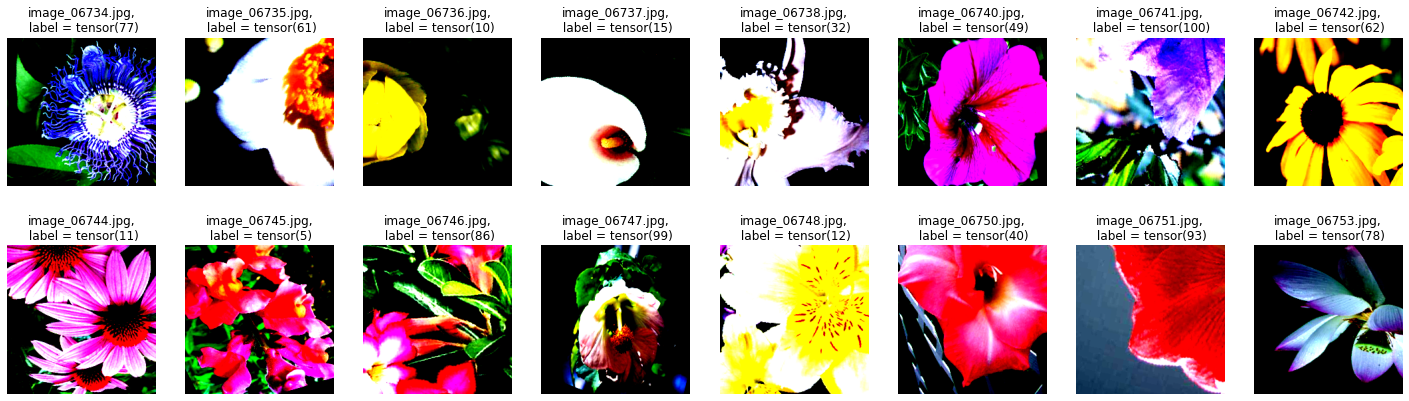

val_dataloader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

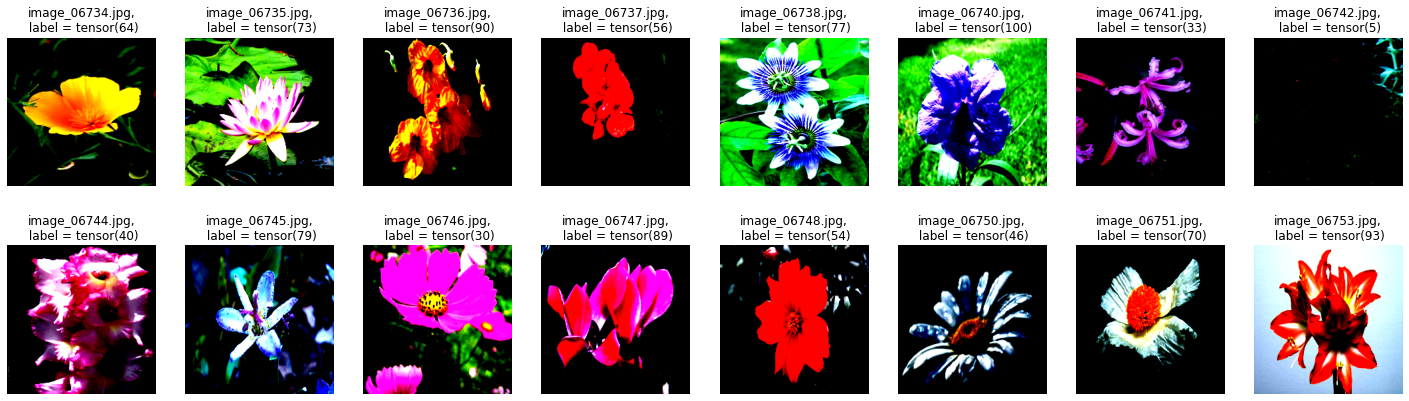

In [21]:
def plot_examples(inputs, classes):
  figure = plt.figure(figsize=(25, 7))
  cols, rows = 8, 2
  for i in range(0, cols * rows):
    img, label = inputs[i], classes[i]
    figure.add_subplot(rows, cols, i+1)
    img = img.numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    filename = filelist['filename'][i]
    plt.title(f'{filename},\n label = {str(label)}')
    plt.axis("off")
    plt.imshow(img)
  plt.show()

print('train_dataloader:')
inputs, classes = next(iter(train_dataloader))
plot_examples(inputs, classes)
print('val_dataloader:')
inputs, classes = next(iter(val_dataloader))
plot_examples(inputs, classes)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
net = models.resnet34()
net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [35]:
net.fc = torch.nn.Linear(512, len(filelist['label'].unique()))

In [43]:
net = net.to(device)

In [44]:
learning_rate = 1e-2
batch_size = 64
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [45]:
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        print(epoch)
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_dataloader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        net.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(val_dataloader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

In [63]:
import inspect
print(inspect.getsource(models.resnet34))

def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



In [65]:
net = models.resnet34(pretrained=True)
for parameter in net.parameters():
    parameter.requres_grad = False
net.fc = torch.nn.Linear(512, len(filelist['label'].unique()))
net = net.to(device)

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, val_dataset, 30)

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()


In [ ]:
net = models.resnet152(pretrained=True)
for parameter in net.parameters():
    parameter.requres_grad = False
net.fc = torch.nn.Linear(512, len(filelist['label'].unique()))
net = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, val_dataset, 30)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)

loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, val_dataset, 30)

### Сохранение модели

Допустим, мы уже обучили модель. Нам надо как-то сохранить ее веса. Для этого в PyTorch есть функция save().

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
print(model.state_dict().keys())

Теперь для того, чтобы загрузить модель нам необходимо создать класс модели и вызвать метод load(). 

In [ ]:
model = FullyConnectedNetwork()
model.load_state_dict(torch.load('model_weights.pth'))


Мы также можем запиклить всю модель!

In [11]:
torch.save(model, 'model.pth')

NameError: ignored

In [12]:
model_loaded = torch.load('model.pth')

FileNotFoundError: ignored

In [ ]:
print(type(model_loaded))

Обратите внимание, что хоть мы и можем загрузить класс модели, мы все равно должны сохранять ее код неизменным, потому что при загрузке нам понадобится определение данного класса.

### Сохранение чекпоинтов
Практически всегда нам необходимо сохранять не только сами модели но и некоторые дополнительные параметры, такие как номер эпохи, состояние оптимизатора, значение лосса, значение метрик и т.д.

In [13]:
path_to_save_checkpoint = 'checkpoint.pth'
torch.save(
    {
        'epoch': 100,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': 0.001,
    }, 
    path_to_save_checkpoint
)

NameError: ignored

In [14]:
model = FullyConnectedNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


checkpoint = torch.load(path_to_save_checkpoint)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


print(f'Loss {loss}')
print(f'Epoch {epoch}')
print(optimizer)

NameError: ignored